In [44]:
!pip install causal-conv1d mamba-ssm

  Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [75]:
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Compose
from mamba_ssm.models.mixer_seq_simple import MambaConfig, MambaLMHeadModel

In [46]:
MNIST?

Init signature:
MNIST(
    root: str,
    train: bool = True,
    transform: Optional[Callable] = None,
    target_transform: Optional[Callable] = None,
    download: bool = False,
) -> None
Docstring:     
`MNIST <http://yann.lecun.com/exdb/mnist/>`_ Dataset.

Args:
    root (string): Root directory of dataset where ``MNIST/raw/train-images-idx3-ubyte``
        and  ``MNIST/raw/t10k-images-idx3-ubyte`` exist.
    train (bool, optional): If True, creates dataset from ``train-images-idx3-ubyte``,
        otherwise from ``t10k-images-idx3-ubyte``.
    download (bool, optional): If True, downloads the dataset from the internet and
        puts it in root directory. If dataset is already downloaded, it is not
        downloaded again.
    transform (callable, optional): A function/transform that  takes in an PIL image
        and returns a transformed version. E.g, ``transforms.RandomCrop``
    target_transform (callable, optional): A function/transform that takes in the
        target and

In [47]:
root = os.path.expanduser("~/.cache/torchvision")
os.makedirs(root, exist_ok=True)

In [48]:
train_ds, val_ds = MNIST(root=root, train=True, download=True), MNIST(root=root, train=False, download=True)

In [49]:
len(train_ds), len(val_ds)

(60000, 10000)

In [50]:
img, digit = next(iter(train_ds))

In [51]:
img

In [52]:
train_ds, val_ds = MNIST(root=root, train=True, download=True, transform=ToTensor()), MNIST(root=root, train=False, download=True, transform=ToTensor())


In [53]:
img, digit = next(iter(train_ds))

In [54]:
img.shape, img.dtype, digit

(torch.Size([1, 28, 28]), torch.float32, 5)

In [55]:
img

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

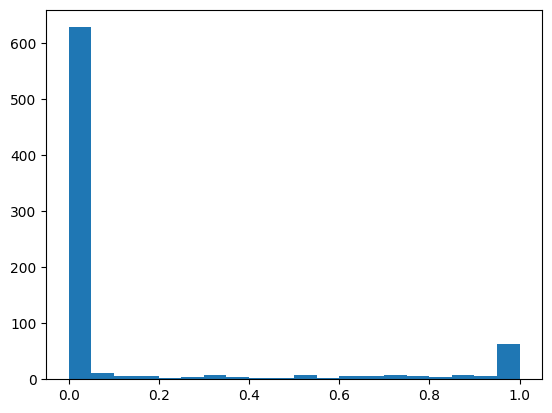

In [56]:
_ = plt.hist(img.flatten(), bins=20)

In [57]:
def binarize(x, threshold: float = 0.5):
    return (x > threshold).to(torch.int32)

In [58]:
binarize(img)

tensor([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1,
          0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 

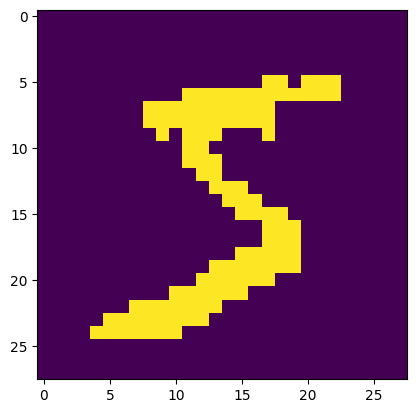

In [59]:
plt.imshow(binarize(img).squeeze(0))

In [60]:
transform = Compose([ToTensor(), binarize])
train_ds = MNIST(root=root, train=True, download=True, transform=transform)
val_ds = MNIST(root=root, train=False, download=True, transform=transform)

In [61]:
n_digits = 10

In [62]:
def collate(items):
    batch = []
    for img, digit in items:
        token_ids = img.flatten()
        token_ids = token_ids + n_digits # offset black and white pixels by the 10 digits
        token_ids = torch.cat((torch.tensor([digit]), token_ids)) # will embed the digit as the prefix
        batch.append(token_ids)
    return torch.stack(batch)

In [63]:
def configure_optimizers(self, *, weight_decay, lr: float, betas: tuple[float, float]):
    # start with all of the candidate parameters
    param_dict = {pn: p for pn, p in self.named_parameters()}
    # filter out those that do not require grad
    param_dict = {pn: p for pn, p in param_dict.items() if p.requires_grad}
    # create optim groups. Any parameters that is 2D will be weight decayed, otherwise no.
    # i.e. all weight tensors in matmuls + embeddings decay, all biases and layernorms don't.
    decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
    nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]
    optim_groups = [
        {"params": decay_params, "weight_decay": weight_decay},
        {"params": nodecay_params, "weight_decay": 0.0},
    ]
    num_decay_params = sum(p.numel() for p in decay_params)
    num_nodecay_params = sum(p.numel() for p in nodecay_params)
    print(
        f"num decayed parameter tensors: {len(decay_params)}, with {num_decay_params:,} parameters"
    )
    print(
        f"num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params:,} parameters"
    )
    # Create AdamW optimizer and use the fused version if it is available
    optimizer = torch.optim.AdamW(optim_groups, lr=lr, betas=betas, fused=True)

    return optimizer

In [64]:
vocab_size = n_digits + 1 + 1

lr = 1e-4


device = "cuda"

mamba_config = MambaConfig(
    d_model=512,
    n_layer=12,
    # d_model=768,
    # n_layer=24,
    vocab_size=vocab_size,
    ssm_cfg={},
    rms_norm=True,
    residual_in_fp32=True,
    fused_add_norm=True,
    pad_vocab_size_multiple=8,
)


model = MambaLMHeadModel(mamba_config).to(device)
optimizer = configure_optimizers(model, weight_decay=0.01, lr=lr, betas=(0.9, 0.95))

num decayed parameter tensors: 73, with 20,307,968 parameters
num non-decayed parameter tensors: 49, with 43,520 parameters


In [84]:
n_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad) / 1e6
print(f"{n_parameters:.1f}M parameters")

20.4M parameters


In [66]:
batch_size = 32

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate, drop_last=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False, collate_fn=collate, drop_last=True)

In [67]:
n_epochs = 3
log_every = 10
max_norm = 1.0

amp_dtype = torch.bfloat16 # change to torch.float16 if your GPU doesn't support bfloat16

assert torch.cuda.is_bf16_supported()

scaler = torch.cuda.amp.GradScaler(enabled=amp_dtype==torch.float16)


losses = []
val_losses = []

step = 0

t1 = time.perf_counter()

for epoch in range(1, n_epochs + 1):
    for token_ids in train_dl:
        token_ids = token_ids.to(device, non_blocking=True)
        input_ids = token_ids[:, :-1].contiguous()
        target_ids = token_ids[:, 1:].contiguous()

        with torch.amp.autocast(dtype=amp_dtype, enabled=True, device_type="cuda"):
            output = model(input_ids)

            logits = output.logits

            loss = F.cross_entropy(
                logits.view(-1, logits.size(-1)),
                target_ids.view(-1),
            )

        scaler.scale(loss).backward()

        scaler.unscale_(optimizer)
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

        scaler.step(optimizer)
        scaler.update()

        optimizer.zero_grad()
        losses.append(loss.item())

        step += 1

        if step % log_every == 0:
            t2 = time.perf_counter()
            throughput = log_every * batch_size / (t2 - t1)
            print(
                f"{step=} loss={loss.item():.3f} grad_norm={grad_norm.item():.3f} {throughput=:.2f} samples/s"
            )
            t1 = t2

    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for token_ids in val_dl:
            token_ids = token_ids.to(device, non_blocking=True)
            input_ids = token_ids[:, :-1].contiguous()
            target_ids = token_ids[:, 1:].contiguous()

            with torch.amp.autocast(dtype=amp_dtype, enabled=True, device_type="cuda"):
                output = model(input_ids)

                logits = output.logits

                loss = F.cross_entropy(
                    logits.view(-1, logits.size(-1)),
                    target_ids.view(-1),
                )

                val_loss += loss.item()

    val_loss = val_loss / len(val_dl)

    val_losses.append(val_loss)

    model.train()

    torch.save(model.state_dict(), f"mama-mnist-{int(n_parameters)}M-{epoch=}.pt")

step=10 loss=0.213 grad_norm=0.591 throughput=65.22 samples/s
step=20 loss=0.219 grad_norm=0.606 throughput=391.89 samples/s
step=30 loss=0.208 grad_norm=0.183 throughput=392.32 samples/s
step=40 loss=0.207 grad_norm=0.130 throughput=392.21 samples/s
step=50 loss=0.210 grad_norm=0.302 throughput=392.54 samples/s
step=60 loss=0.213 grad_norm=0.687 throughput=393.02 samples/s
step=70 loss=0.196 grad_norm=0.280 throughput=392.97 samples/s
step=80 loss=0.183 grad_norm=0.409 throughput=393.03 samples/s
step=90 loss=0.156 grad_norm=0.654 throughput=393.10 samples/s
step=100 loss=0.142 grad_norm=2.371 throughput=393.15 samples/s
step=110 loss=0.125 grad_norm=0.898 throughput=393.07 samples/s
step=120 loss=0.122 grad_norm=1.140 throughput=393.19 samples/s
step=130 loss=0.111 grad_norm=0.507 throughput=393.11 samples/s
step=140 loss=0.112 grad_norm=0.556 throughput=393.13 samples/s
step=150 loss=0.112 grad_norm=0.623 throughput=393.24 samples/s
step=160 loss=0.104 grad_norm=0.461 throughput=393

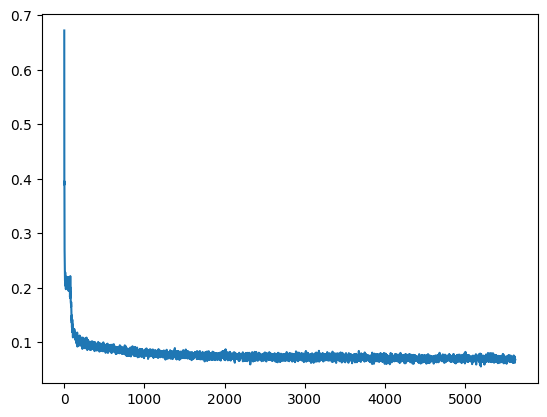

In [85]:
plt.plot(losses)

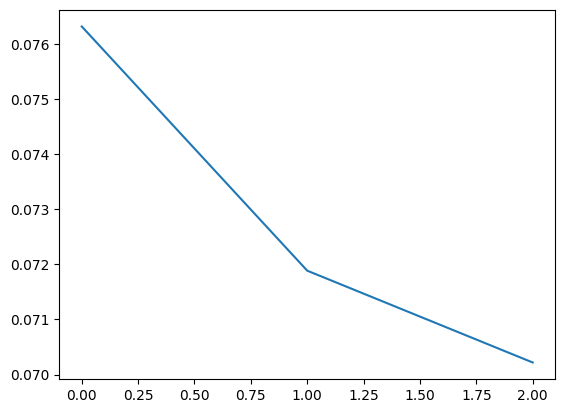

In [86]:
plt.plot(val_losses)

In [70]:
model.eval()

n = 6

generation_batch_size = n * n

# TODO doesn't like autocast here?
with torch.inference_mode():
    input_ids = torch.randint(0, n_digits, (generation_batch_size, 1,), device=device)
    out = model.generate(input_ids, max_length=1 + 28 * 28, temperature=1.0, top_k=2)

generated = out[:, 1:].view(-1, 28, 28).cpu() - n_digits

In [71]:
input_ids.view(n, n)

tensor([[4, 3, 0, 1, 8, 7],
        [3, 8, 6, 8, 2, 9],
        [7, 7, 3, 6, 0, 0],
        [9, 8, 7, 1, 9, 7],
        [1, 2, 7, 9, 0, 6],
        [3, 2, 4, 2, 2, 4]], device='cuda:0')

In [79]:
generated.shape

torch.Size([36, 28, 28])

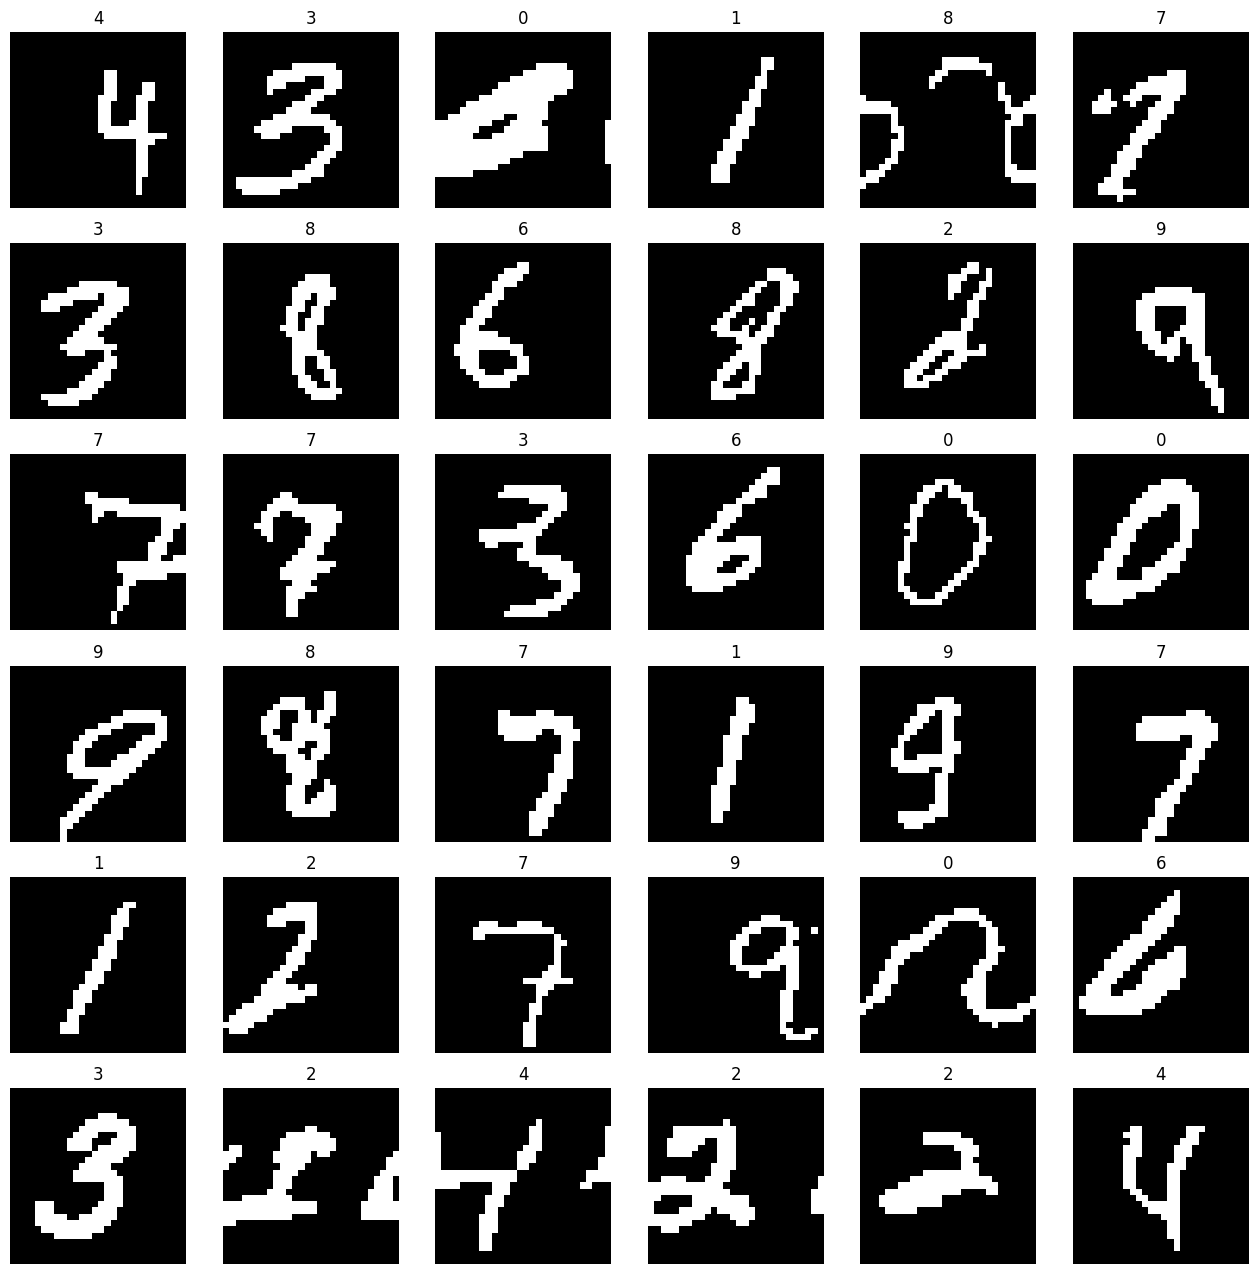

In [83]:
fig, ax = plt.subplots(n, n, figsize=(16, 16))

for i in range(n):
    for j in range(n):
        ax[i, j].imshow(generated[i * n + j], cmap="gray")
        ax[i, j].axis("off")
        ax[i, j].set_title(input_ids[i * n + j].item())